# NHL Linear Regression Project

By Brad Ellisor

## Data Source
Data was downloaded off of Kaggle and contains NHL game data between 2010 and 2018 seasons. 

Data Source https://www.kaggle.com/martinellis/nhl-game-data?select=game_plays.csv

## Purpose of the project:

The focus of the project, I wanted to investigate the relationship between goals scored in a season related to aggressive player metrics like penalty minutes, hits, blocks, etc... so I framed my analysis around the question:

How is the number of goals a player has in a season related to their aggression on the ice?

## EDA

EDA was focused on finding features that were most significant to goal scoring opportunities. 

Two Features were created to add into the model:
* TakeawayDiff - take away diffrential which is the difference between the amount of takaways a player had in season and the amount of giveaways a player had

* faceOffWinP - Face off win percentage which is the amount of a face offs a player won divided by the 

## Hypothesis Testing

## Model Development

## Conclusion
Upon review of the data, there is a statistical relationship between aggressive play and goal scoring. That relationship however is that players with less hits score more goals than players with a high amount of hits. This can be explained by players with a high amount of hits also have a high amount of penalty minutes and therefore less amount of time on the ice. 

When evaluating the importance of features the three most important features to model development were

* Number of shots
* Amount of time on ice
* Number of hits


## Interesting Insights

The average hockey player spends 16.55 minutes on the ice in a given game. 

Players position on the ice has a statistical relationship with their nationality

Centers have the most amount of points (goals+assists) in a season.

Canadiens have the most amount of points but also the highest population in the NHL.



## Import Packages and Read in the Data
We start by adding all the necessary packages to use for the analysis and modeling

In [139]:
# Basic packages to read and interpret data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import researchpy as rp #ResearchPy

# Chi^2 packages for hypothesis testing
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# Anova testing
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
# modeling packages
import statsmodels.api as sm

from statsmodels.formula.api import ols

from scipy.stats.stats import pearsonr
import scipy as sp



from sklearn.linear_model import LinearRegression


from math import exp
from scipy import stats


from sklearn.model_selection import train_test_split

from sklearn import metrics


from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 300)


The data is NHL game level data for every game between 2010 and 2018 seasons. 

In [2]:
# The data is seperated into several different .csv files, we need to read them in then merge them together

player = pd.read_csv('game_skater_stats.csv')
plays = pd.read_csv('game_plays.csv')
player_info = pd.read_csv('player_info.csv')
skater_stats= pd.read_csv('game_skater_stats.csv')
team_stats = pd.read_csv('game_teams_stats.csv')
team_info = pd.read_csv('team_info.csv')
teams = team_info.merge(team_stats, on='team_id')
players = player_info.merge(skater_stats, on='player_id')
game= pd.read_csv('game.csv')

# Plays

The first dataset to explore is NHL plays data. This way we can get a look at goals and shots metrics. 

In [3]:
plays.shape

(3632349, 20)

In [4]:
nullplays= plays.isna().sum()
nullplays/len(plays)

play_id                0.000000
game_id                0.000000
play_num               0.000000
team_id_for            0.193093
team_id_against        0.193093
event                  0.000000
secondaryType          0.784459
x                      0.195173
y                      0.195168
period                 0.000000
periodType             0.000000
periodTime             0.000000
periodTimeRemaining    0.000000
dateTime               0.000000
goals_away             0.000000
goals_home             0.000000
description            0.000000
st_x                   0.195173
st_y                   0.195168
rink_side              0.216773
dtype: float64

In [5]:
plays.head()

,play_id,game_id,play_num,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,rink_side
0,2011030221_1,2011030221,1,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200,2012-04-29 18:16:06,0,0,Game Scheduled,NaN,NaN,NaN
1,2011030221_2,2011030221,2,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200,2012-04-29 19:19:49,0,0,Period Ready,NaN,NaN,NaN
2,2011030221_3,2011030221,3,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200,2012-04-29 19:20:13,0,0,Period Start,NaN,NaN,NaN
3,2011030221_4,2011030221,4,4.0,1.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200,2012-04-29 19:20:13,0,0,Sean Couturier faceoff won against Patrik Elias,0.0,0.0,right
4,2011030221_5,2011030221,5,4.0,1.0,Giveaway,NaN,28.0,24.0,1,REGULAR,21,1179,2012-04-29 19:21:02,0,0,Giveaway by Kimmo Timonen,-28.0,-24.0,right


In [6]:
plays.columns

Index(['play_id', 'game_id', 'play_num', 'team_id_for', 'team_id_against',
       'event', 'secondaryType', 'x', 'y', 'period', 'periodType',
       'periodTime', 'periodTimeRemaining', 'dateTime', 'goals_away',
       'goals_home', 'description', 'st_x', 'st_y', 'rink_side'],
      dtype='object')

In [7]:
plays.event.unique()

array(['Game Scheduled', 'Period Ready', 'Period Start', 'Faceoff',
       'Giveaway', 'Blocked Shot', 'Shot', 'Hit', 'Stoppage', 'Goal',
       'Penalty', 'Takeaway', 'Missed Shot', 'Period End',
       'Period Official', 'Game End', 'Game Official',
       'Official Challenge', 'Shootout Complete',
       'Early Intermission Start', 'Early Intermission End',
       'Emergency Goaltender'], dtype=object)

In [8]:
plays['event']

0           Game Scheduled
1             Period Ready
2             Period Start
3                  Faceoff
4                 Giveaway
                ...       
3632344            Faceoff
3632345               Shot
3632346         Period End
3632347    Period Official
3632348           Game End
Name: event, Length: 3632349, dtype: object

## Shots

In [9]:
#Plays that are shots
shots=plays[(plays.event == 'Shot') | (plays.event == 'Missed Shot') | (plays.event == 'Blocked Shot') | (plays.event == 'Shot')]
shots.head()

,play_id,game_id,play_num,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,rink_side
5,2011030221_6,2011030221,6,4.0,1.0,Blocked Shot,NaN,52.0,28.0,1,REGULAR,26,1174,2012-04-29 19:21:07,0,0,Max Talbot blocked shot from Patrik Elias,-52.0,-28.0,right
6,2011030221_7,2011030221,7,1.0,4.0,Shot,Wrist Shot,80.0,-3.0,1,REGULAR,30,1170,2012-04-29 19:21:12,0,0,Patrik Elias Wrist Shot saved by Ilya Bryzgalov,80.0,-3.0,left
11,2011030221_12,2011030221,12,1.0,4.0,Shot,Wrap-around,88.0,-4.0,1,REGULAR,139,1061,2012-04-29 19:23:29,0,0,Ryan Carter Wrap-around saved by Ilya Bryzgalov,88.0,-4.0,left
12,2011030221_13,2011030221,13,1.0,4.0,Shot,Wrist Shot,81.0,-27.0,1,REGULAR,154,1046,2012-04-29 19:23:44,0,0,Stephen Gionta Wrist Shot saved by Ilya Bryzgalov,81.0,-27.0,left
24,2011030221_25,2011030221,25,1.0,4.0,Shot,Snap Shot,63.0,-19.0,1,REGULAR,274,926,2012-04-29 19:28:00,1,0,Travis Zajac Snap Shot saved by Ilya Bryzgalov,63.0,-19.0,left


There are three kinds of shots: shots on goal (shot), missed shot, and blocked shot

blocked shots for corsi rating, use team_id_against; otherwise use team_id_for

In [10]:
shots.shape

(1217675, 20)

In [11]:
shotsg= shots.groupby(shots['event'])

In [12]:
shotsg.head()

,play_id,game_id,play_num,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,rink_side
5,2011030221_6,2011030221,6,4.0,1.0,Blocked Shot,NaN,52.0,28.0,1,REGULAR,26,1174,2012-04-29 19:21:07,0,0,Max Talbot blocked shot from Patrik Elias,-52.0,-28.0,right
6,2011030221_7,2011030221,7,1.0,4.0,Shot,Wrist Shot,80.0,-3.0,1,REGULAR,30,1170,2012-04-29 19:21:12,0,0,Patrik Elias Wrist Shot saved by Ilya Bryzgalov,80.0,-3.0,left
11,2011030221_12,2011030221,12,1.0,4.0,Shot,Wrap-around,88.0,-4.0,1,REGULAR,139,1061,2012-04-29 19:23:29,0,0,Ryan Carter Wrap-around saved by Ilya Bryzgalov,88.0,-4.0,left
12,2011030221_13,2011030221,13,1.0,4.0,Shot,Wrist Shot,81.0,-27.0,1,REGULAR,154,1046,2012-04-29 19:23:44,0,0,Stephen Gionta Wrist Shot saved by Ilya Bryzgalov,81.0,-27.0,left
24,2011030221_25,2011030221,25,1.0,4.0,Shot,Snap Shot,63.0,-19.0,1,REGULAR,274,926,2012-04-29 19:28:00,1,0,Travis Zajac Snap Shot saved by Ilya Bryzgalov,63.0,-19.0,left
25,2011030221_26,2011030221,26,1.0,4.0,Shot,Snap Shot,68.0,1.0,1,REGULAR,282,918,2012-04-29 19:28:08,1,0,Travis Zajac Snap Shot saved by Ilya Bryzgalov,68.0,1.0,left
33,2011030221_34,2011030221,34,1.0,4.0,Missed Shot,NaN,74.0,-27.0,1,REGULAR,417,783,2012-04-29 19:31:13,1,0,Ryan Carter - Wide of Net,74.0,-27.0,left
37,2011030221_38,2011030221,38,4.0,1.0,Blocked Shot,NaN,53.0,10.0,1,REGULAR,427,773,2012-04-29 19:33:34,1,0,Jaromir Jagr blocked shot from Bryce Salvador,-53.0,-10.0,right
38,2011030221_39,2011030221,39,4.0,1.0,Blocked Shot,NaN,46.0,-17.0,1,REGULAR,441,759,2012-04-29 19:33:48,1,0,Scott Hartnell blocked shot from Marek Zidlicky,-46.0,17.0,right
46,2011030221_47,2011030221,47,4.0,1.0,Blocked Shot,NaN,61.0,18.0,1,REGULAR,534,666,2012-04-29 19:35:51,1,0,Andreas Lilja blocked shot from Anton Volchenkov,-61.0,-18.0,right


In [13]:
Goals = plays[plays['event']== 'Goal']
totalgoals= Goals.groupby('secondaryType').count()

[Text(0, 0, 'Wrist Shot'),
 Text(0, 0, 'Snap Shot'),
 Text(0, 0, 'Slap Shot'),
 Text(0, 0, 'Backhand'),
 Text(0, 0, 'Tip-In'),
 Text(0, 0, 'Deflected'),
 Text(0, 0, 'Wrap-around')]

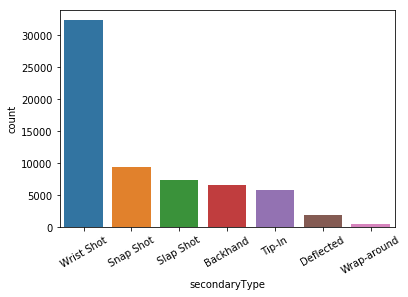

In [14]:
plot = sns.countplot(x = 'secondaryType',
                    data = Goals,
                    order = Goals['secondaryType'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 30)

# Players

In [15]:
players.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link,game_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
0,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,2011030221,1,999,0,0,1,3,0,0,0,0,0,0,0,0,0,0,-1,885,98,16
1,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,2011030222,1,993,0,0,1,4,0,0,0,0,0,0,0,0,0,1,0,919,54,20
2,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,2011030223,1,1091,1,1,4,3,0,0,0,1,1,0,0,0,0,0,1,1023,68,0
3,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,2011030224,1,995,0,0,1,2,0,0,0,0,0,0,0,0,0,0,1,899,41,55
4,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,2011030225,1,688,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,636,40,12


In [16]:
players.columns

Index(['player_id', 'firstName', 'lastName', 'nationality', 'birthCity',
       'primaryPosition', 'birthDate', 'link', 'game_id', 'team_id',
       'timeOnIce', 'assists', 'goals', 'shots', 'hits', 'powerPlayGoals',
       'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken',
       'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists',
       'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce',
       'powerPlayTimeOnIce'],
      dtype='object')

In [17]:
players.shape

(411578, 29)

In [18]:
player = pd.merge(player, player_info, on ='player_id', how = 'left')
player =pd.merge(player, team_info, on = 'team_id', how = 'left')
player.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link_x,franchiseId,shortName,teamName,abbreviation,link_y
0,2011030221,8467412,1,999,0,0,1,3,0,0,0,0,0,0,0,0,0,0,-1,885,98,16,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,23,New Jersey,Devils,NJD,/api/v1/teams/1
1,2011030221,8468501,1,1168,0,0,0,4,0,0,0,0,0,1,1,0,0,1,0,767,401,0,Anton,Volchenkov,RUS,Moscow,D,1982-02-25,/api/v1/people/8468501,23,New Jersey,Devils,NJD,/api/v1/teams/1
2,2011030221,8470609,1,558,0,0,2,1,0,0,0,0,2,0,0,0,0,1,-1,542,0,16,Steve,Bernier,CAN,Quebec City,RW,1985-03-31,/api/v1/people/8470609,23,New Jersey,Devils,NJD,/api/v1/teams/1
3,2011030221,8471816,1,1134,0,0,1,4,0,0,0,0,0,1,0,0,0,1,-1,935,183,16,Mark,Fayne,USA,Nashua,D,1987-05-15,/api/v1/people/8471816,23,New Jersey,Devils,NJD,/api/v1/teams/1
4,2011030221,8472410,1,436,0,0,1,3,0,0,0,3,6,0,0,0,0,0,-1,436,0,0,Stephen,Gionta,USA,Rochester,RW,1983-10-09,/api/v1/people/8472410,23,New Jersey,Devils,NJD,/api/v1/teams/1


Text(0.5, 1.0, 'Time on Ice Distribution by Minutes')

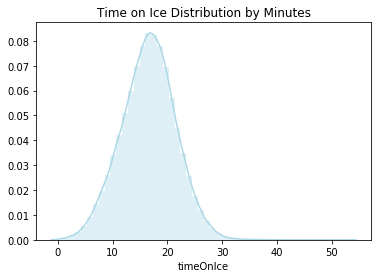

In [19]:
dist=sns.distplot(player.timeOnIce/60, color='lightblue')
dist.set_title('Time on Ice Distribution by Minutes')

In [20]:
player['timeOnIce'].describe()

count    411578.000000
mean        993.614911
std         297.877325
min           1.000000
25%         798.000000
50%        1001.000000
75%        1192.000000
max        3197.000000
Name: timeOnIce, dtype: float64

In [21]:
993/60

16.55

In [22]:
player['GoalsPerMin']= (player.goals*60)/player.timeOnIce
player['PointsPerMin']=(player.assists + player.goals)*60/player.timeOnIce
player.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link_x,franchiseId,shortName,teamName,abbreviation,link_y,GoalsPerMin,PointsPerMin
0,2011030221,8467412,1,999,0,0,1,3,0,0,0,0,0,0,0,0,0,0,-1,885,98,16,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0
1,2011030221,8468501,1,1168,0,0,0,4,0,0,0,0,0,1,1,0,0,1,0,767,401,0,Anton,Volchenkov,RUS,Moscow,D,1982-02-25,/api/v1/people/8468501,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0
2,2011030221,8470609,1,558,0,0,2,1,0,0,0,0,2,0,0,0,0,1,-1,542,0,16,Steve,Bernier,CAN,Quebec City,RW,1985-03-31,/api/v1/people/8470609,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0
3,2011030221,8471816,1,1134,0,0,1,4,0,0,0,0,0,1,0,0,0,1,-1,935,183,16,Mark,Fayne,USA,Nashua,D,1987-05-15,/api/v1/people/8471816,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0
4,2011030221,8472410,1,436,0,0,1,3,0,0,0,3,6,0,0,0,0,0,-1,436,0,0,Stephen,Gionta,USA,Rochester,RW,1983-10-09,/api/v1/people/8472410,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0


In [23]:
playeractive= player[player['timeOnIce']>= 300]
top10players = playeractive.nlargest(10, 'GoalsPerMin')
top10players = top10players[['firstName', 'lastName', 'primaryPosition', 'GoalsPerMin', 'goals']]
top10players

,firstName,lastName,primaryPosition,GoalsPerMin,goals
75700,Tomas,Hertl,C,0.357143,4
380560,Zach,Parise,LW,0.312500,3
186046,Frank,Vatrano,C,0.292208,3
74183,Nick,Bonino,C,0.289389,3
314224,Matt,Kassian,LW,0.280374,2
235728,Patrice,Bergeron,C,0.279720,4
341432,Blake,Geoffrion,C,0.279070,3
286713,Andreas,Johnsson,LW,0.277778,3
221364,Scott,Hartnell,LW,0.275229,3
236623,Jack,Skille,RW,0.273349,2


In [24]:
player['Points']= player.goals +player.assists

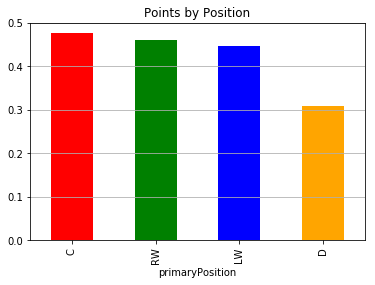

In [25]:
positions=player.groupby('primaryPosition').Points.mean().loc[["C", "RW", "LW","D"]].plot(kind='bar',color=['r', 'g', 'b', 'orange'],title='Points by Position').grid(axis='y')

In [133]:
player.primaryPosition.value_counts()

D     138324
C     119473
LW     81403
RW     72378
Name: primaryPosition, dtype: int64

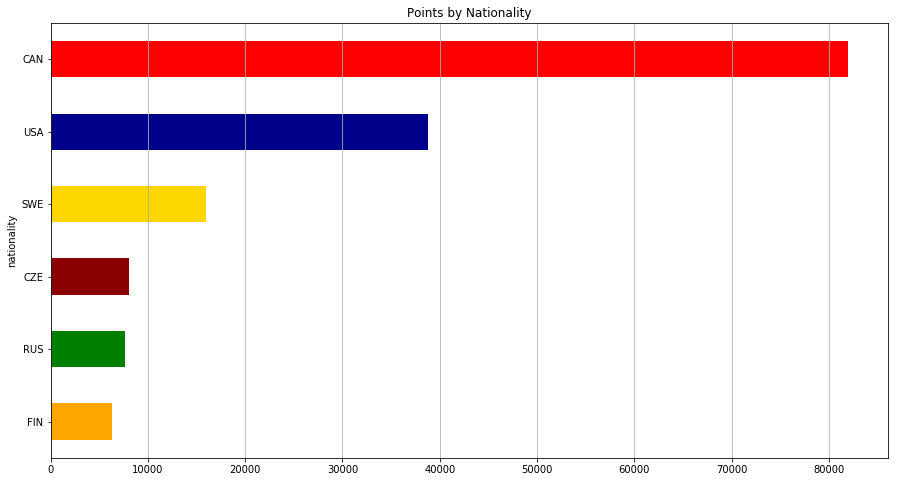

In [26]:
nat = player.groupby(['nationality'])['Points'].agg('sum').nlargest(6)
nat.sort_values(ascending=True).plot(kind='barh', 
                                     figsize = (15,8), 
                                     color=['orange', 'g', 'darkred', 'gold', 'darkblue', 'red'],
                                    title='Points by Nationality').grid(axis='x')

In [27]:
hits= player.groupby('hits').agg('sum')
hits.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,franchiseId,GoalsPerMin,PointsPerMin,Points
hits,,,,,,,,,,,,,,,,,,,,,,,,,
0,301798132792401,1269538911133,2611163,148437483,43663,25744,263245,5785,11655,66180,284343,569643,60754,68559,715,661,108170,1832,123749081,9401812,15286590,3300404,1558.508537,4120.083986,69407
1,238371311715171,1002766558390,2062686,117397487,30877,18001,199482,3931,7533,63919,201644,403203,45658,53343,492,534,94982,-825,98592170,8343660,10461657,2602123,1095.941057,2890.729090,48878
2,143012698862126,601623447635,1235123,70584810,16852,9771,116358,2024,3676,44143,106266,212721,26236,31696,292,323,60925,-1842,59730248,5320062,5534500,1554051,598.862369,1579.433766,26623
3,76547556911244,322019637960,670425,37862744,8123,4872,60934,986,1667,25819,50883,101805,13661,16967,141,168,34129,-1289,32247145,2941487,2674112,831524,297.166553,768.186893,12995
4,37346427919111,157111970443,322495,18593778,3783,2335,29576,451,718,13549,23984,47531,6383,8397,74,77,16867,-641,15905805,1460669,1227304,402162,143.535921,362.123742,6118


In [28]:
teams.columns

Index(['team_id', 'franchiseId', 'shortName', 'teamName', 'abbreviation',
       'link', 'game_id', 'HoA', 'won', 'settled_in', 'head_coach', 'goals',
       'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals',
       'faceOffWinPercentage', 'giveaways', 'takeaways'],
      dtype='object')

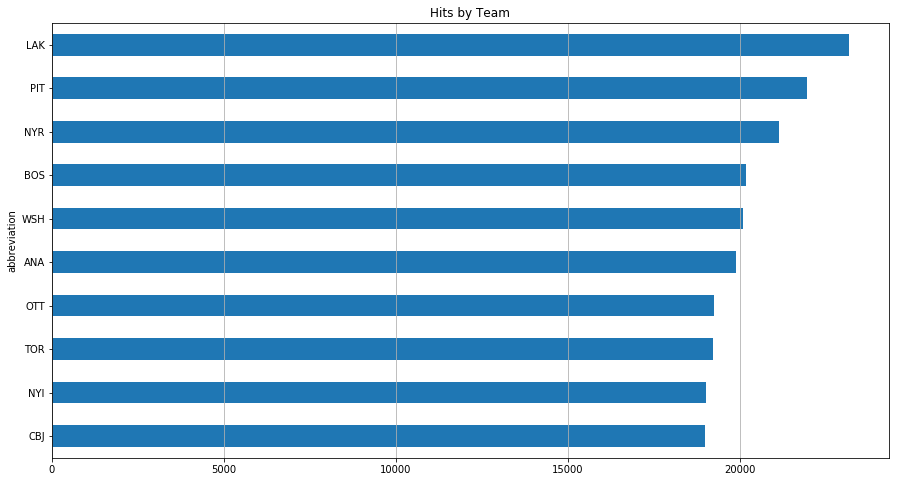

In [29]:
teamhits=player.groupby(['abbreviation'])['hits'].agg('sum').nlargest(10)
teamhits.sort_values(ascending=True).plot(kind='barh',
                                         figsize=(15,8),
                                         title='Hits by Team').grid(axis='x')

In [30]:
teams.faceOffWinPercentage =teams.faceOffWinPercentage.astype(int)
teams.won= teams.won.astype(int)

In [31]:
teams['TakeawayDiff']= (teams.takeaways - teams.giveaways)

In [32]:
teamwins = teams.groupby(['abbreviation'])['won'].agg('sum')
teamwins

abbreviation
ANA    423
ARI    157
ATL     34
BOS    465
BUF    276
CAR    319
CBJ    359
CGY    350
CHI    436
COL    332
DAL    372
DET    357
EDM    285
FLA    317
LAK    406
MIN    373
MTL    380
NJD    328
NSH    418
NYI    352
NYR    426
OTT    338
PHI    367
PHX    152
PIT    478
SJS    442
STL    445
TBL    449
TOR    341
VAN    360
VGK    110
WPG    326
WSH    461
Name: won, dtype: int64

In [33]:
teamgamesplayed = teams.groupby(['abbreviation'])['game_id'].agg('count')
teamgamesplayed.sort_values(ascending=False)

abbreviation
PIT    815
BOS    812
SJS    805
WSH    804
NYR    802
CHI    793
TBL    790
STL    788
NSH    787
LAK    783
ANA    774
MTL    751
DET    751
MIN    748
OTT    746
PHI    745
VAN    744
NYI    736
DAL    736
NJD    733
TOR    731
CBJ    731
COL    729
CGY    724
CAR    719
FLA    717
EDM    717
BUF    711
WPG    649
ARI    410
PHX    314
VGK    191
ATL     82
Name: game_id, dtype: int64

In [34]:
GameWinPercentage= teamwins/teamgamesplayed


In [35]:
GameWinPercentage.sort_values(ascending = False)


abbreviation
PIT    0.586503
VGK    0.575916
WSH    0.573383
BOS    0.572660
TBL    0.568354
STL    0.564721
CHI    0.549811
SJS    0.549068
ANA    0.546512
NYR    0.531172
NSH    0.531131
LAK    0.518519
MTL    0.505992
DAL    0.505435
WPG    0.502311
MIN    0.498663
PHI    0.492617
CBJ    0.491108
PHX    0.484076
VAN    0.483871
CGY    0.483425
NYI    0.478261
DET    0.475366
TOR    0.466484
COL    0.455418
OTT    0.453083
NJD    0.447476
CAR    0.443672
FLA    0.442120
ATL    0.414634
EDM    0.397490
BUF    0.388186
ARI    0.382927
dtype: float64

In [36]:
player['season'] = player.game_id.astype(str).str[:4]


In [37]:
player.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link_x,franchiseId,shortName,teamName,abbreviation,link_y,GoalsPerMin,PointsPerMin,Points,season
0,2011030221,8467412,1,999,0,0,1,3,0,0,0,0,0,0,0,0,0,0,-1,885,98,16,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0,0,2011
1,2011030221,8468501,1,1168,0,0,0,4,0,0,0,0,0,1,1,0,0,1,0,767,401,0,Anton,Volchenkov,RUS,Moscow,D,1982-02-25,/api/v1/people/8468501,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0,0,2011
2,2011030221,8470609,1,558,0,0,2,1,0,0,0,0,2,0,0,0,0,1,-1,542,0,16,Steve,Bernier,CAN,Quebec City,RW,1985-03-31,/api/v1/people/8470609,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0,0,2011
3,2011030221,8471816,1,1134,0,0,1,4,0,0,0,0,0,1,0,0,0,1,-1,935,183,16,Mark,Fayne,USA,Nashua,D,1987-05-15,/api/v1/people/8471816,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0,0,2011
4,2011030221,8472410,1,436,0,0,1,3,0,0,0,3,6,0,0,0,0,0,-1,436,0,0,Stephen,Gionta,USA,Rochester,RW,1983-10-09,/api/v1/people/8472410,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0,0,2011


In [38]:
player.columns

Index(['game_id', 'player_id', 'team_id', 'timeOnIce', 'assists', 'goals',
       'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes',
       'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways',
       'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus',
       'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce',
       'firstName', 'lastName', 'nationality', 'birthCity', 'primaryPosition',
       'birthDate', 'link_x', 'franchiseId', 'shortName', 'teamName',
       'abbreviation', 'link_y', 'GoalsPerMin', 'PointsPerMin', 'Points',
       'season'],
      dtype='object')

In [39]:
season_stats = player.groupby(['player_id','team_id', 'season'], as_index= False).agg(
    {
        'timeOnIce':sum, #sum time on ice 
        'assists':sum, #sum assists
        'goals':sum,
        'shots':sum,
        'hits':sum,
        'powerPlayGoals':sum,
        'powerPlayAssists':sum,
        'penaltyMinutes':sum,
        'faceOffWins':sum,
        'faceoffTaken':sum,
        'takeaways':sum,
        'giveaways':sum,
        'shortHandedGoals':sum,
        'shortHandedAssists':sum,
        'blocked':sum,
        'plusMinus':sum,
        'evenTimeOnIce':sum,
        'shortHandedTimeOnIce':sum,
        'powerPlayTimeOnIce':sum,
        
        
    
    }


)

In [40]:
season_stats.shape

(8646, 22)

In [41]:
season_stats.season.unique()

array(['2010', '2013', '2014', '2011', '2012', '2015', '2016', '2017',
       '2018'], dtype=object)

In [42]:
player_info.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link
0,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412
1,8468501,Anton,Volchenkov,RUS,Moscow,D,1982-02-25,/api/v1/people/8468501
2,8459670,Kimmo,Timonen,FIN,Kuopio,D,1975-03-18,/api/v1/people/8459670
3,8471233,Travis,Zajac,CAN,Winnipeg,C,1985-05-13,/api/v1/people/8471233
4,8455710,Martin,Brodeur,CAN,Montreal,G,1972-05-06,/api/v1/people/8455710


In [43]:
player_season = pd.merge(season_stats, player_info, on ='player_id', how = 'left')
player_season =pd.merge(season_stats, team_info, on = 'team_id', how = 'left')
player_season.head()

,player_id,team_id,season,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,franchiseId,shortName,teamName,abbreviation,link
0,8446485,17,2010,33946,6,6,60,59,0,0,14,118,220,19,8,0,0,16,3,31092,2718,136,12,Detroit,Red Wings,DET,/api/v1/teams/17
1,8448208,1,2013,94259,43,24,231,4,5,12,46,0,2,36,59,0,0,9,16,79753,246,14260,23,New Jersey,Devils,NJD,/api/v1/teams/1
2,8448208,1,2014,60473,18,11,119,13,2,5,42,0,0,31,34,0,0,8,-10,52621,36,7816,23,New Jersey,Devils,NJD,/api/v1/teams/1
3,8448208,4,2011,81465,42,20,196,15,8,18,32,0,2,24,50,0,0,15,0,65413,70,15982,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
4,8448208,6,2012,35831,17,2,86,16,0,5,10,0,0,15,23,0,0,7,2,30713,11,5107,6,Boston,Bruins,BOS,/api/v1/teams/6


In [44]:
player_season = pd.merge(season_stats, player_info, on ='player_id')

In [45]:
player_season

,player_id,team_id,season,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link
0,8446485,17,2010,33946,6,6,60,59,0,0,14,118,220,19,8,0,0,16,3,31092,2718,136,Kris,Draper,CAN,Toronto,C,1971-05-24,/api/v1/people/8446485
1,8448208,1,2013,94259,43,24,231,4,5,12,46,0,2,36,59,0,0,9,16,79753,246,14260,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208
2,8448208,1,2014,60473,18,11,119,13,2,5,42,0,0,31,34,0,0,8,-10,52621,36,7816,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208
3,8448208,4,2011,81465,42,20,196,15,8,18,32,0,2,24,50,0,0,15,0,65413,70,15982,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208
4,8448208,6,2012,35831,17,2,86,16,0,5,10,0,0,15,23,0,0,7,2,30713,11,5107,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8641,8481442,13,2018,760,0,0,1,2,0,0,0,0,0,0,0,0,0,1,1,760,0,0,Brady,Keeper,CAN,Cross Lake,D,1996-06-05,/api/v1/people/8481442
8642,8481477,30,2018,1534,0,0,7,3,0,0,0,5,17,0,0,0,0,2,0,1434,86,14,Nico,Sturm,DEU,Augsburg,C,1995-05-03,/api/v1/people/8481477
8643,8481479,23,2018,1602,0,0,3,0,0,0,0,0,0,1,1,0,0,2,-1,1602,0,0,Brogan,Rafferty,USA,WEST DUNDEE,D,1995-05-28,/api/v1/people/8481479
8644,8481481,26,2018,672,0,0,1,0,0,0,0,4,8,1,0,0,0,1,-1,672,0,0,Blake,Lizotte,NaN,NaN,C,1997-12-13,/api/v1/people/8481481


In [46]:
player_season.columns

Index(['player_id', 'team_id', 'season', 'timeOnIce', 'assists', 'goals',
       'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes',
       'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways',
       'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus',
       'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce',
       'firstName', 'lastName', 'nationality', 'birthCity', 'primaryPosition',
       'birthDate', 'link'],
      dtype='object')

In [47]:
df= player_season

In [48]:
df.isnull().sum()

player_id               0
team_id                 0
season                  0
timeOnIce               0
assists                 0
goals                   0
shots                   0
hits                    0
powerPlayGoals          0
powerPlayAssists        0
penaltyMinutes          0
faceOffWins             0
faceoffTaken            0
takeaways               0
giveaways               0
shortHandedGoals        0
shortHandedAssists      0
blocked                 0
plusMinus               0
evenTimeOnIce           0
shortHandedTimeOnIce    0
powerPlayTimeOnIce      0
firstName               0
lastName                0
nationality             2
birthCity               3
primaryPosition         0
birthDate               0
link                    0
dtype: int64

In [49]:
df.dropna(inplace=True)

In [50]:
df.to_csv('final_data.csv')

In [51]:
df['GoalsPerMin']= (df.goals*60)/df.timeOnIce
df['PointsPerMin']=(df.assists + df.goals)*60/df.timeOnIce
df.head()

,player_id,team_id,season,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link,GoalsPerMin,PointsPerMin
0,8446485,17,2010,33946,6,6,60,59,0,0,14,118,220,19,8,0,0,16,3,31092,2718,136,Kris,Draper,CAN,Toronto,C,1971-05-24,/api/v1/people/8446485,0.010605,0.021210
1,8448208,1,2013,94259,43,24,231,4,5,12,46,0,2,36,59,0,0,9,16,79753,246,14260,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208,0.015277,0.042648
2,8448208,1,2014,60473,18,11,119,13,2,5,42,0,0,31,34,0,0,8,-10,52621,36,7816,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208,0.010914,0.028773
3,8448208,4,2011,81465,42,20,196,15,8,18,32,0,2,24,50,0,0,15,0,65413,70,15982,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208,0.014730,0.045664
4,8448208,6,2012,35831,17,2,86,16,0,5,10,0,0,15,23,0,0,7,2,30713,11,5107,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208,0.003349,0.031816


In [52]:
df['takeawayDiff']= (df.takeaways - df.giveaways)

In [53]:
df['faceOffWinP'] = (df.faceOffWins/df.faceoffTaken)

In [54]:
df.columns

Index(['player_id', 'team_id', 'season', 'timeOnIce', 'assists', 'goals',
       'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes',
       'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways',
       'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus',
       'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce',
       'firstName', 'lastName', 'nationality', 'birthCity', 'primaryPosition',
       'birthDate', 'link', 'GoalsPerMin', 'PointsPerMin', 'takeawayDiff',
       'faceOffWinP'],
      dtype='object')

In [55]:
df.corr()

,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,GoalsPerMin,PointsPerMin,takeawayDiff,faceOffWinP
player_id,1.000000,0.044527,-0.161309,-0.114421,-0.061565,-0.098201,-0.108219,-0.094608,-0.112232,-0.202471,-0.074063,-0.066721,-0.062011,-0.082091,-0.035832,-0.069526,-0.128036,-0.004848,-0.144748,-0.202327,-0.136839,0.014984,-0.023378,0.042543,-0.066461
team_id,0.044527,1.000000,0.005223,0.001809,0.001117,0.001338,0.003578,-0.002471,-0.003448,-0.008335,0.004602,0.003639,0.001703,-0.014858,-0.004946,-0.004782,0.006396,0.001087,0.005477,0.005648,0.000823,0.012671,0.015022,0.022742,0.006792
timeOnIce,-0.161309,0.005223,1.000000,0.831399,0.664843,0.853551,0.601024,0.546895,0.645900,0.506748,0.328408,0.334160,0.791599,0.858086,0.282737,0.357164,0.754279,0.197361,0.995083,0.691577,0.753407,0.206842,0.351853,-0.277831,0.025268
assists,-0.114421,0.001809,0.831399,1.000000,0.788763,0.866004,0.353775,0.702849,0.874981,0.374501,0.439974,0.448874,0.811298,0.779166,0.265613,0.310272,0.428620,0.281521,0.808606,0.374206,0.884780,0.334122,0.589264,-0.144644,0.027227
goals,-0.061565,0.001117,0.664843,0.788763,1.000000,0.886308,0.343529,0.839925,0.649266,0.343940,0.450020,0.461311,0.771552,0.573151,0.371152,0.216289,0.153667,0.233727,0.644726,0.200065,0.795088,0.583329,0.640478,0.096951,0.018309
shots,-0.098201,0.001338,0.853551,0.866004,0.886308,1.000000,0.485619,0.748217,0.714255,0.444562,0.386179,0.394962,0.832213,0.740036,0.329258,0.278521,0.411828,0.190773,0.838996,0.397700,0.849578,0.420032,0.539635,-0.065636,0.006671
hits,-0.108219,0.003578,0.601024,0.353775,0.343529,0.485619,1.000000,0.217405,0.162272,0.675098,0.131994,0.133229,0.405546,0.450272,0.189808,0.217544,0.505947,0.097115,0.618995,0.509210,0.265803,0.093442,0.107342,-0.157236,0.011583
powerPlayGoals,-0.094608,-0.002471,0.546895,0.702849,0.839925,0.748217,0.217405,1.000000,0.679515,0.250696,0.352703,0.358739,0.591787,0.506385,0.175883,0.140212,0.133121,0.113814,0.512519,0.091162,0.808451,0.458230,0.539921,-0.018932,0.026955
powerPlayAssists,-0.112232,-0.003448,0.645900,0.874981,0.649266,0.714255,0.162272,0.679515,1.000000,0.237654,0.353856,0.360064,0.618238,0.649284,0.146386,0.177893,0.300862,0.120229,0.606426,0.193994,0.881434,0.272088,0.499369,-0.187812,0.018353
penaltyMinutes,-0.202471,-0.008335,0.506748,0.374501,0.343940,0.444562,0.675098,0.250696,0.237654,1.000000,0.144120,0.144716,0.362933,0.411635,0.149644,0.179659,0.356870,0.079120,0.518939,0.345495,0.305562,0.113616,0.153038,-0.152835,0.006835


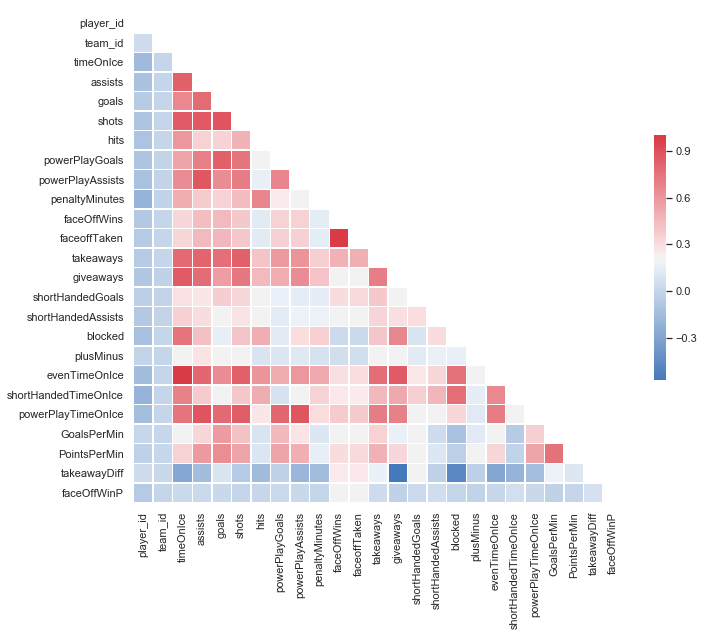

In [176]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)


CorrMtx(df, dropDuplicates = True)

Dealing with multicollinearity

Some statistics have a high correlation:
* Takeaways and giveaways
* even time on ice and time on ice
* faceoffwins and faceoffs taken

That is why takeaway diffrential and face off win percentage were calculated

The models will be focused on even time on ice (5v5)

In [56]:
df.to_csv('final_data.csv')

# Hypothesis Testing

In [141]:
df[['hits', 'penaltyMinutes']].corr()['hits']

hits              1.000000
penaltyMinutes    0.675098
Name: hits, dtype: float64

Text(0.5, 1.0, 'Penalties Distribution by Minutes in a Season')

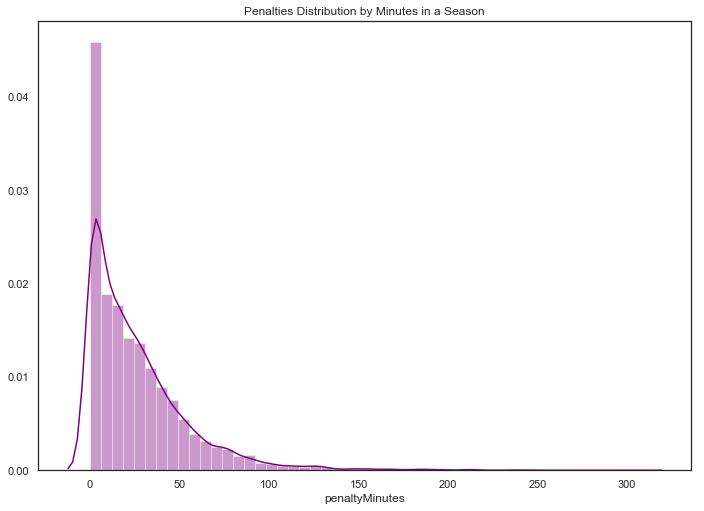

In [186]:
dist1=sns.distplot(df.penaltyMinutes, color='purple', norm_hist=True)
dist1.set_title('Penalties Distribution by Minutes in a Season')

In [58]:
df.penaltyMinutes.describe()

count    8642.000000
mean       26.229924
std        28.248398
min         0.000000
25%         6.000000
50%        18.000000
75%        38.000000
max       307.000000
Name: penaltyMinutes, dtype: float64

Text(0.5, 1.0, 'Distribution of Hits in a Season')

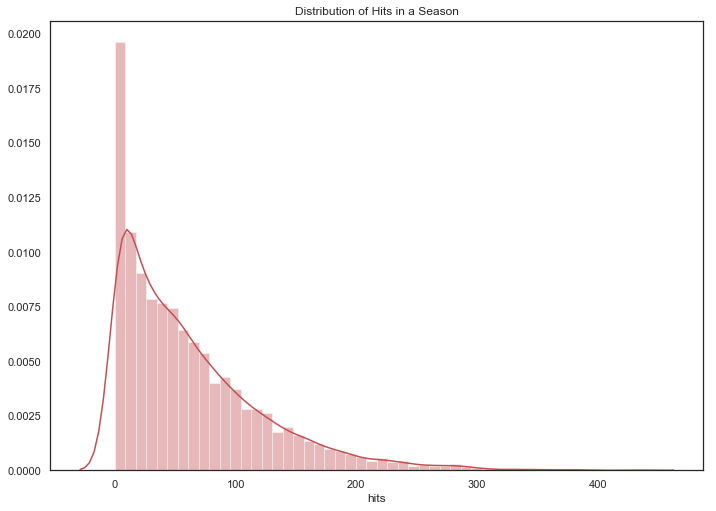

In [185]:
dist2=sns.distplot(df.hits, color='r', norm_hist=True)
dist2.set_title('Distribution of Hits in a Season')

In [60]:
df.hits.describe()

count    8642.000000
mean       62.461699
std        59.886284
min         0.000000
25%        16.000000
50%        46.000000
75%        91.000000
max       434.000000
Name: hits, dtype: float64

In [61]:
df.dtypes

player_id                 int64
team_id                   int64
season                   object
timeOnIce                 int64
assists                   int64
goals                     int64
shots                     int64
hits                      int64
powerPlayGoals            int64
powerPlayAssists          int64
penaltyMinutes            int64
faceOffWins               int64
faceoffTaken              int64
takeaways                 int64
giveaways                 int64
shortHandedGoals          int64
shortHandedAssists        int64
blocked                   int64
plusMinus                 int64
evenTimeOnIce             int64
shortHandedTimeOnIce      int64
powerPlayTimeOnIce        int64
firstName                object
lastName                 object
nationality              object
birthCity                object
primaryPosition          object
birthDate                object
link                     object
GoalsPerMin             float64
PointsPerMin            float64
takeaway

## Hypothesis Test 1

Hypothesis Test: Chi^2 Contingency
we want to see whether there is a statistical difference between Nationality of a player and the position they play

Null Hypothesis, there is no statistical difference between a player's nationality and the position they play.

Alternate Hypothesis, there is a relationship between a player's nationality and the position they play.

In [187]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
table =  pd.crosstab(df['primaryPosition'],[df['nationality']])

stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
#interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f)' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (regject H0)')
else:
    print('Independent (fail to reject H0)')
#interpret p-value
alpha= 1-prob
print('signigicance=%.3f, p=%.3f,' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else: 
    print('Independent (fail to reject)')


dof=72
[[8.43901875e-01 9.28292062e+00 2.81300625e-01 4.21950937e+00
  1.22618942e+03 2.75674612e+01 1.00705624e+02 1.71593381e+01
  1.80032400e+01 7.56698681e+01 7.03251562e+00 1.12520250e+00
  8.43901875e-01 8.43901875e-01 1.96910437e+00 5.34471187e+00
  5.62601250e-01 1.12520250e+00 4.50081000e+00 8.07332793e+01
  3.03804675e+01 3.37560750e+00 1.87064916e+02 3.37560750e+00
  6.22799583e+02]
 [1.02580421e+00 1.12838463e+01 3.41934737e-01 5.12902106e+00
  1.49049352e+03 3.35096043e+01 1.22412636e+02 2.08580190e+01
  2.18838232e+01 9.19804443e+01 8.54836843e+00 1.36773895e+00
  1.02580421e+00 1.02580421e+00 2.39354316e+00 6.49676001e+00
  6.83869475e-01 1.36773895e+00 5.47095580e+00 9.81352696e+01
  3.69289516e+01 4.10321685e+00 2.27386600e+02 4.10321685e+00
  7.57043508e+02]
 [6.01943994e-01 6.62138394e+00 2.00647998e-01 3.00971997e+00
  8.74624624e+02 1.96635038e+01 7.18319833e+01 1.22395279e+01
  1.28414719e+01 5.39743115e+01 5.01619995e+00 8.02591993e-01
  6.01943994e-01 6.01943994

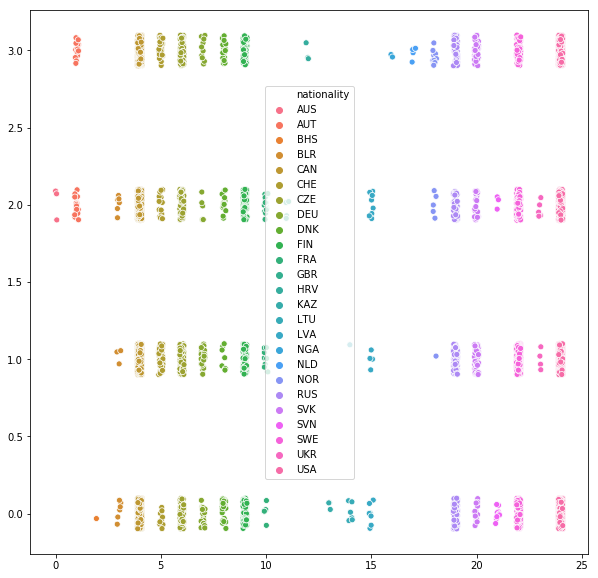

In [63]:
df.nationality = pd.Categorical(df.nationality)
df.primaryPosition = pd.Categorical(df.primaryPosition)

plt.figure(figsize=(10,10))
axes = sns.scatterplot(x=df.nationality.cat.codes+np.random.uniform(-0.1,0.1, len(df)), 
                       y=df.primaryPosition.cat.codes+np.random.uniform(-0.1,0.1, len(df)),
                       hue = df.nationality,
                      )


There appears to be a statistically significant relationship between the nationality of a player and their primary postion. However, this is likely due to some countries being under represented in ratio to the United States and Canada.

## Hypothesis test 2 ##
Is there a statistical difference betweeen the position a player plays and the number of hits a player has in a season.

Null hypothesis, all skaters have the same amount of hits, regardless of position and are not statistically different

Alternate hypothesis, there is a statistial difference between number of hits a player has in season and their position.

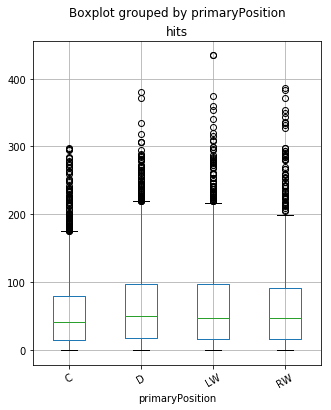

In [64]:
df.boxplot('hits', 'primaryPosition', rot=30, figsize=(5,6))

In [65]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['hits'], df['primaryPosition'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     C      D   10.522  0.001  6.3205 14.7235   True
     C     LW  11.1119  0.001  6.2887 15.9351   True
     C     RW   8.1467  0.001  3.1313 13.1622   True
     D     LW   0.5899    0.9 -4.0518  5.2317  False
     D     RW  -2.3752 0.5776 -7.2164  2.4659  False
    LW     RW  -2.9652 0.4911 -8.3547  2.4244  False
----------------------------------------------------


In [66]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['goals'], df['primaryPosition'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     C      D   -6.047  0.001 -6.6508 -5.4432   True
     C     LW   -0.044    0.9 -0.7371  0.6492  False
     C     RW   0.1652    0.9 -0.5556   0.886  False
     D     LW    6.003  0.001   5.336  6.6701   True
     D     RW   6.2122  0.001  5.5165   6.908   True
    LW     RW   0.2092 0.8956 -0.5654  0.9837  False
----------------------------------------------------


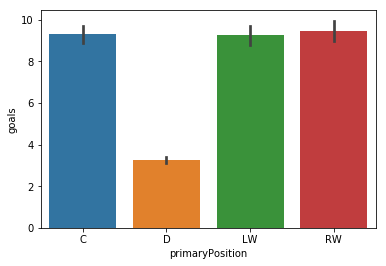

In [67]:
bar = sns.barplot(x= 'primaryPosition', y= 'goals', data =df)

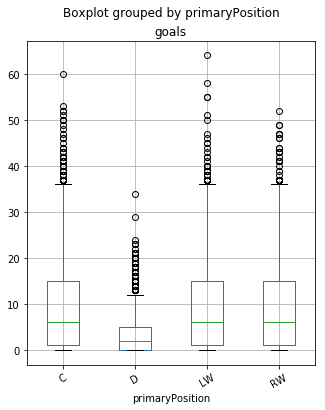

In [68]:
df.boxplot('goals', 'primaryPosition', rot=30, figsize=(5,6))

In [69]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['goals'], df['nationality'])
mc_results = mc.tukeyhsd()
print(mc_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   AUS    AUT  13.7273 0.6446  -6.1271 33.5816  False
   AUS    BHS  -0.3333    0.9 -38.3515 37.6849  False
   AUS    BLR  11.6667    0.9  -9.1568 32.4901  False
   AUS    CAN   6.7605    0.9 -12.2551 25.7761  False
   AUS    CHE   6.3095    0.9 -12.9883 25.6074  False
   AUS    CZE    7.594    0.9 -11.4945 26.6826  False
   AUS    DEU   5.7158    0.9 -13.7551 25.1868  False
   AUS    DNK   9.6667    0.9  -9.7829 29.1162  False
   AUS    FIN   8.0756    0.9 -11.0392 27.1904  False
   AUS    FRA   4.6267    0.9 -15.4907  24.744  False
   AUS    GBR  10.9167    0.9   -14.23 36.0633  False
   AUS    HRV      0.0    0.9 -26.8829 26.8829  False
   AUS    KAZ     12.0    0.9 -14.8829 38.8829  False
   AUS    LTU   7.6667    0.9 -15.0536 30.3869  False
   AUS    LVA   3.5614    0.9 -16.8934 24.0162  False
   AUS    NGA   0.6667    0.

[Text(0, 0, 'CAN'),
 Text(0, 0, 'USA'),
 Text(0, 0, 'SWE'),
 Text(0, 0, 'CZE'),
 Text(0, 0, 'RUS'),
 Text(0, 0, 'FIN'),
 Text(0, 0, 'SVK'),
 Text(0, 0, 'CHE'),
 Text(0, 0, 'DNK'),
 Text(0, 0, 'DEU'),
 Text(0, 0, 'AUT'),
 Text(0, 0, 'FRA'),
 Text(0, 0, 'LVA'),
 Text(0, 0, 'NOR'),
 Text(0, 0, 'BLR'),
 Text(0, 0, 'UKR'),
 Text(0, 0, 'SVN'),
 Text(0, 0, 'LTU'),
 Text(0, 0, 'NLD'),
 Text(0, 0, 'GBR'),
 Text(0, 0, 'HRV'),
 Text(0, 0, 'KAZ'),
 Text(0, 0, 'AUS'),
 Text(0, 0, 'NGA'),
 Text(0, 0, 'BHS')]

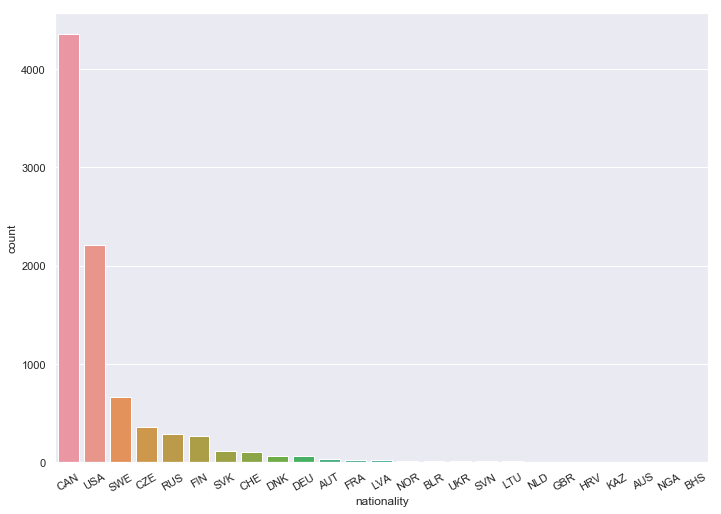

In [70]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plot = sns.countplot(x = 'nationality',
                    data = df,
                    order = df['nationality'].value_counts().index
                    )
plot.set_xticklabels(plot.get_xticklabels(), rotation = 30)


In [116]:
df.nationality.value_counts()

CAN    4359
USA    2214
SWE     665
CZE     358
RUS     287
FIN     269
SVK     108
CHE      98
DNK      64
DEU      61
AUT      33
FRA      25
LVA      19
NOR      16
BLR      15
UKR      12
SVN      12
LTU       7
NLD       4
GBR       4
HRV       3
KAZ       3
AUS       3
NGA       2
BHS       1
Name: nationality, dtype: int64

# Hypothesis Test 3

In [184]:
# Is there a statistically significant difference between the offensive and defensive players
# in their takeaway differnential  for a season?

#NH There is no difference in takeaway chances in a season depending on whehter a player is on offense or defense
# AH There is a stastically significant difference between the offense of defense and their takeaway diffrential
c_df = df.loc[(df['primaryPosition'] == 'C')]
rw_df = df.loc[(df['primaryPosition'] == 'RW')]
lw_df = df.loc[(df['primaryPosition'] == 'LW')]
off_df = pd.concat([c_df, rw_df, lw_df], axis=0)
d_df = df.loc[(df['primaryPosition'] == 'D')]

stats.ttest_ind(off_df['takeawayDiff'], d_df['takeawayDiff'], equal_var = False)

Ttest_indResult(statistic=48.157318012450034, pvalue=0.0)

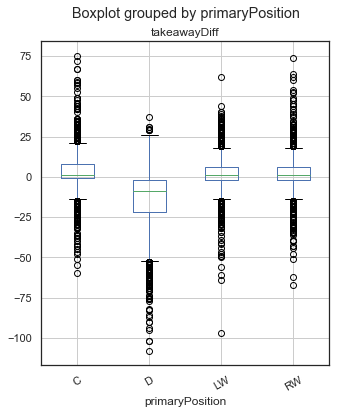

In [183]:
df.boxplot('takeawayDiff', 'primaryPosition', rot=30, figsize=(5,6))

There is a statistical difference between a players position and their takeaway diffrential

Defensemen are more likely to lose a puck whereas offensive player tend to take the puck away. 

# Model Development

In [175]:
from scipy.stats import sem, t
from scipy import mean
confidence = 0.95

data = df['goals']

n = len(data)
m = mean(data)
# find Standard error of the mean
std_err_p = sem(data)

h = std_err_p * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
print(start)


end = m + h
print(end)

7.066934286550306
7.448687097388597


The confidence interval for goals is between 7.06 and 7.44. This means that the we can say with 95% certainty that the true mean of goals scored in a season is between 7.06 and 7.44

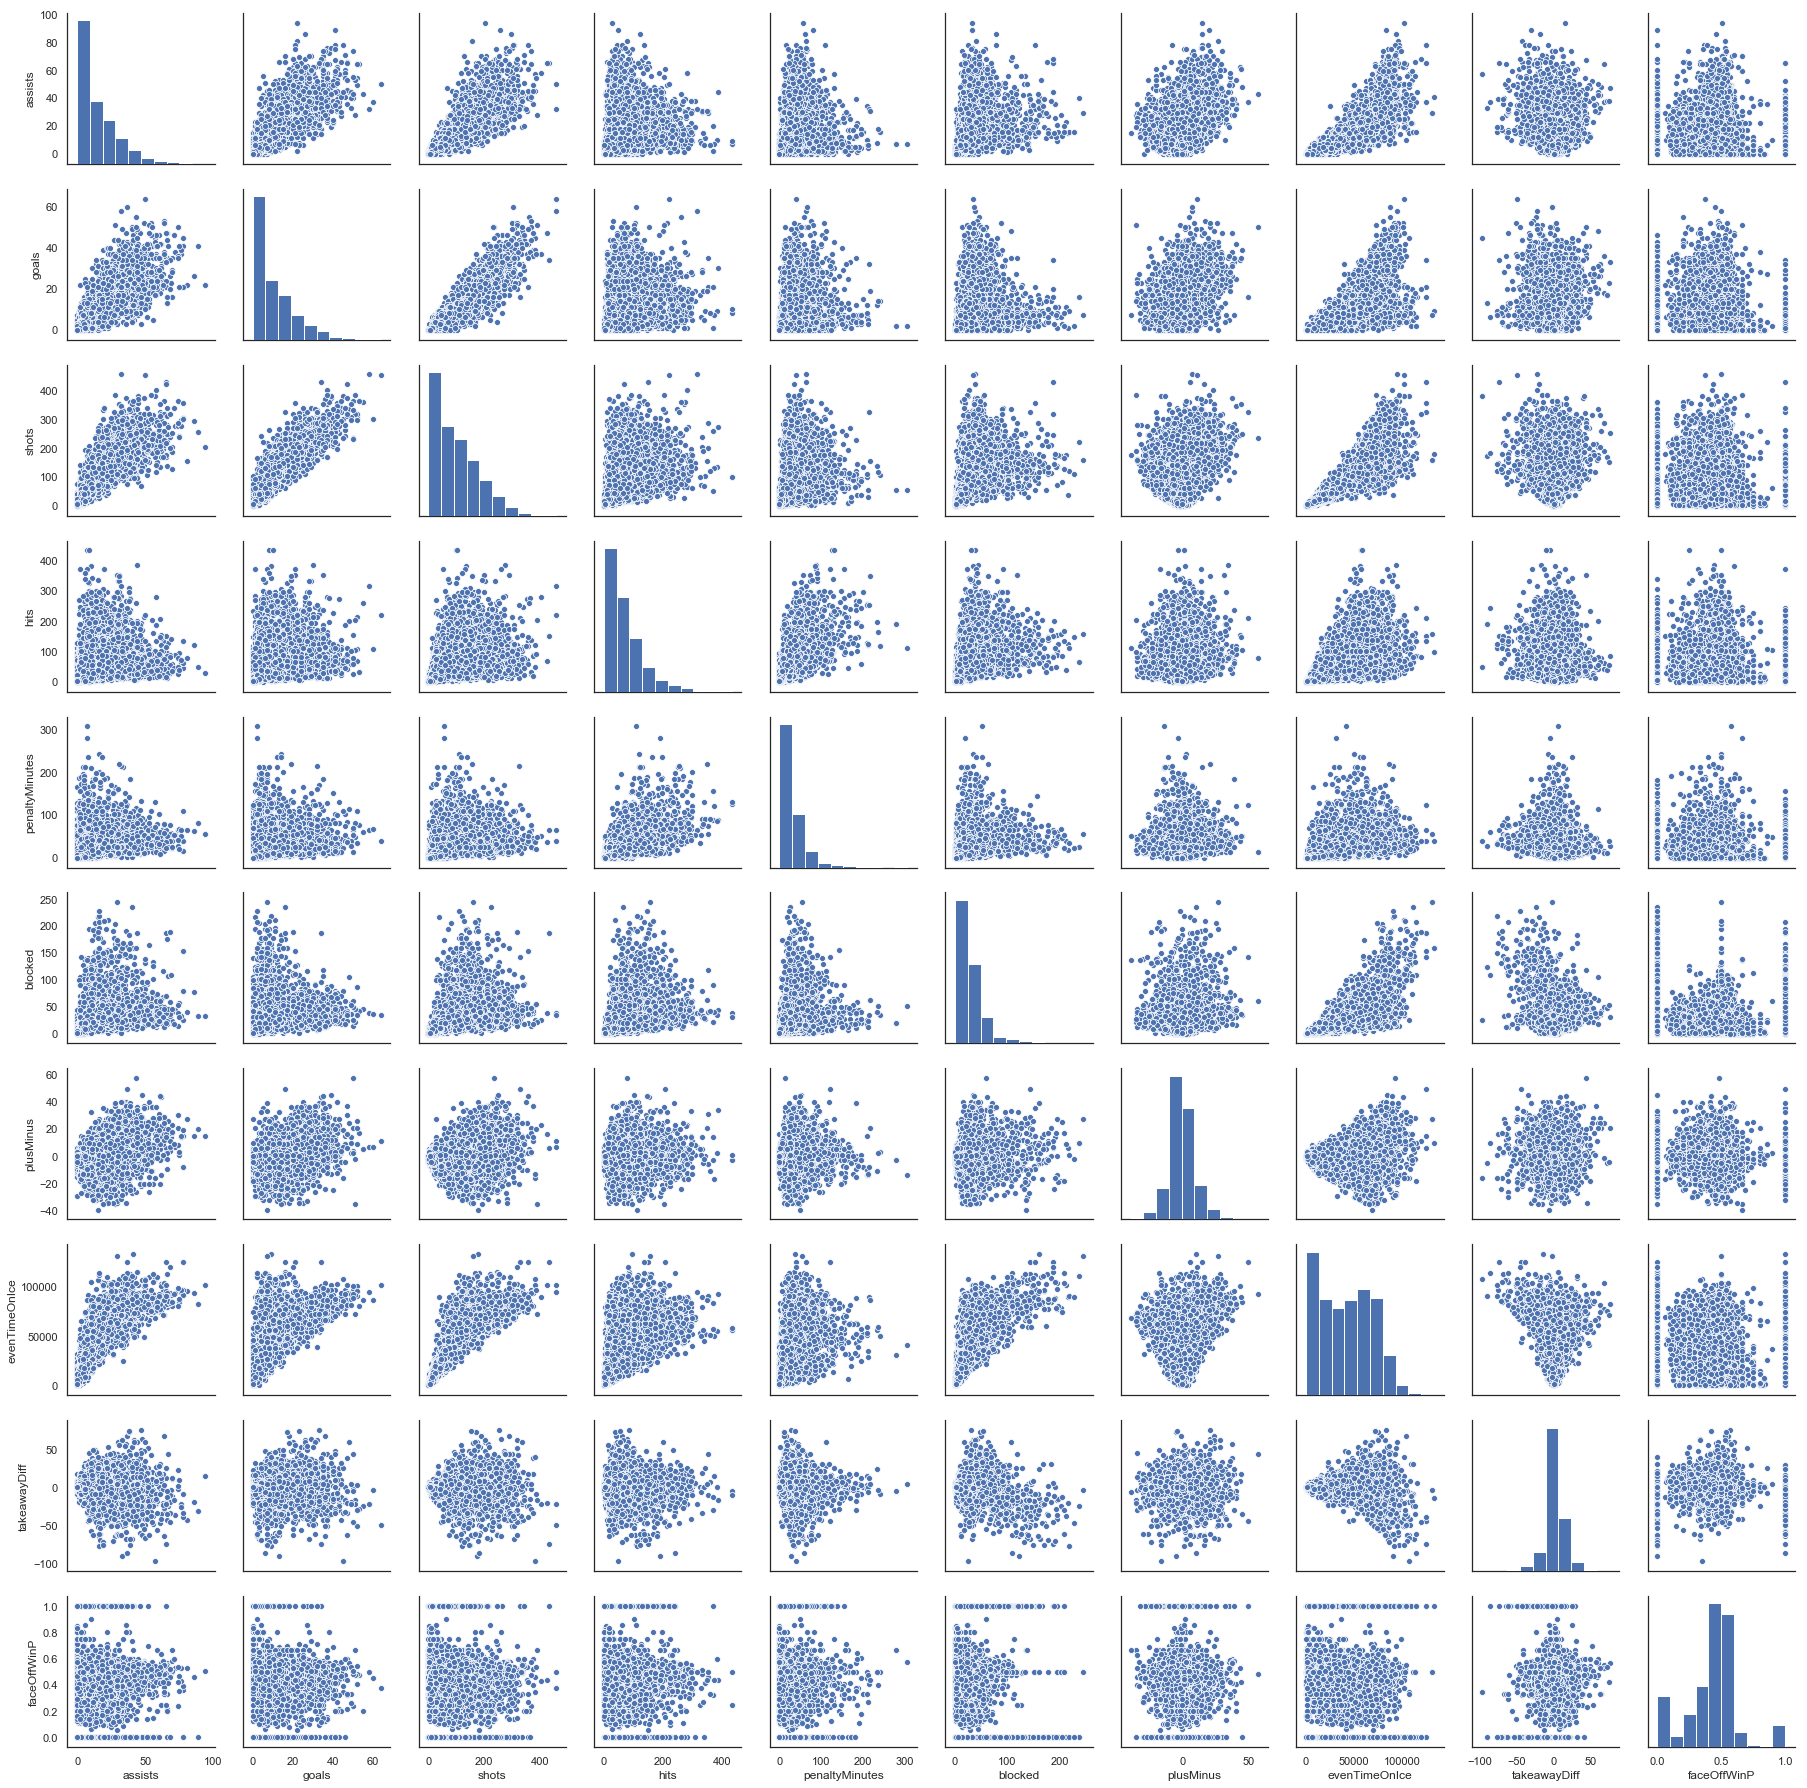

In [147]:
sns.pairplot(mdf)

In [73]:
def scatter_plot(feature, target):
    plt.figure(figsize=(16,8))
    plt.scatter(
        df[feature],
        df[target],
        c='black'
    )
    plt.xlabel('Number of {} in a season'.format(feature))
    plt.ylabel('Goasl in a season')
    plt.show()



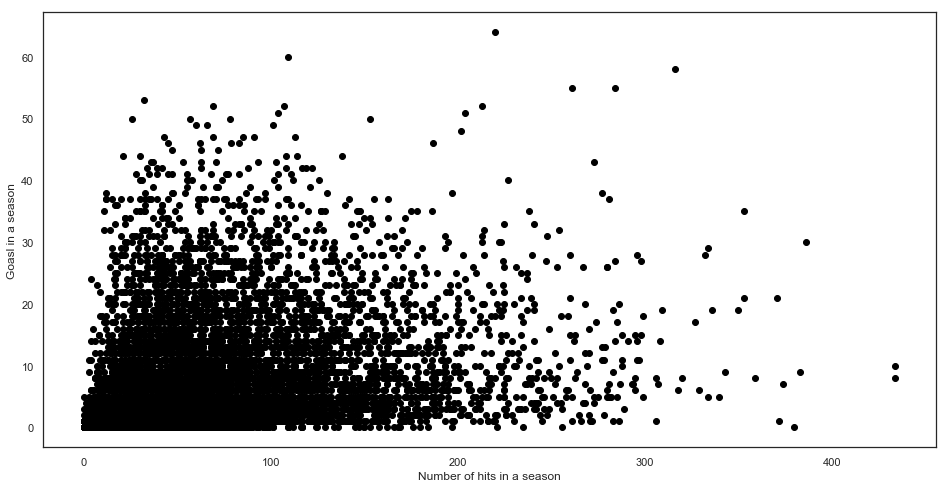

In [74]:
scatter_plot('hits','goals')

In [75]:
lr_model = ols(formula='goals~hits', data=df).fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  goals   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     1156.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):          6.26e-238
Time:                        15:30:09   Log-Likelihood:                -30758.
No. Observations:                8642   AIC:                         6.152e+04
Df Residuals:                    8640   BIC:                         6.153e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0144      0.132     30.378      0.000       3.755       4.273
hits           0.0519      0.002     34.001      0.000       0.049       0.055
==============================================================================
Omnibus:                     3052.094   Durbin-Watson:                   0.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10122.485
Skew:                           1.814   Prob(JB):                         0.00
Kurtosis:                       6.867   Cond. No.                         125.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

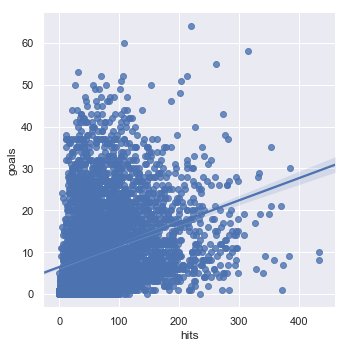

In [148]:
sns.set(color_codes=True)
sns.lmplot(x='hits', y = 'goals', data = mdf)

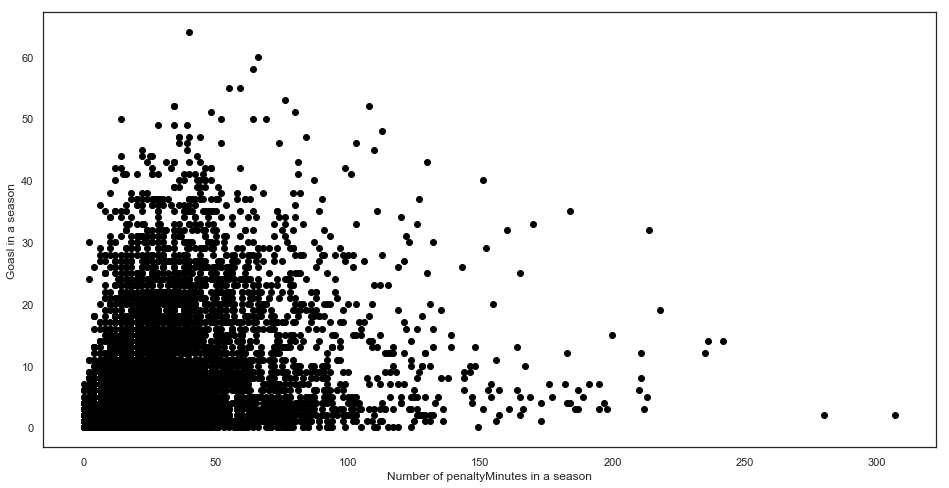

In [76]:
scatter_plot('penaltyMinutes', 'goals')

In [77]:
lr_model = ols(formula='goals~penaltyMinutes', data=df).fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  goals   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     1159.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):          1.56e-238
Time:                        15:30:09   Log-Likelihood:                -30756.
No. Observations:                8642   AIC:                         6.152e+04
Df Residuals:                    8640   BIC:                         6.153e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.3669      0.125     34.996      0.000       4.122       4.611
penaltyMinutes     0.1102      0.003     34.047      0.000       0.104       0.117
==============================================================================
Omnibus:                     2729.268   Durbin-Watson:                   0.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8513.309
Skew:                           1.630   Prob(JB):                         0.00
Kurtosis:                       6.608   Cond. No.                         52.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

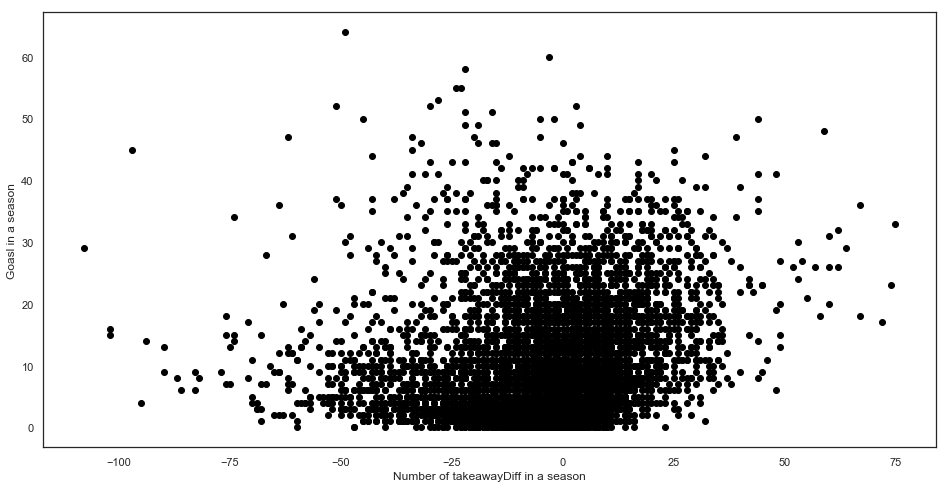

In [78]:
scatter_plot('takeawayDiff','goals')

In [79]:
lr_model = ols(formula='goals~takeawayDiff', data=df).fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  goals   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     81.98
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.67e-19
Time:                        15:30:09   Log-Likelihood:                -31259.
No. Observations:                8642   AIC:                         6.252e+04
Df Residuals:                    8640   BIC:                         6.254e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.4402      0.099     75.160      0.000       7.246       7.634
takeawayDiff     0.0563      0.006      9.054      0.000       0.044       0.068
==============================================================================
Omnibus:                     2905.690   Durbin-Watson:                   0.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8758.909
Skew:                           1.767   Prob(JB):                         0.00
Kurtosis:                       6.441   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
df.dtypes

player_id                  int64
team_id                    int64
season                    object
timeOnIce                  int64
assists                    int64
goals                      int64
shots                      int64
hits                       int64
powerPlayGoals             int64
powerPlayAssists           int64
penaltyMinutes             int64
faceOffWins                int64
faceoffTaken               int64
takeaways                  int64
giveaways                  int64
shortHandedGoals           int64
shortHandedAssists         int64
blocked                    int64
plusMinus                  int64
evenTimeOnIce              int64
shortHandedTimeOnIce       int64
powerPlayTimeOnIce         int64
firstName                 object
lastName                  object
nationality             category
birthCity                 object
primaryPosition         category
birthDate                 object
link                      object
GoalsPerMin              float64
PointsPerM

Create a simplified dataframe to run regression models off of.

In [81]:
mdf = df.drop(['timeOnIce', 'player_id','team_id','season', 'powerPlayGoals', 'powerPlayAssists', 'faceOffWins','faceoffTaken',
             'takeaways', 'giveaways','shortHandedGoals', 'shortHandedAssists', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce',
             'firstName', 'lastName', 'nationality', 'birthCity', 'primaryPosition', 'birthDate', 'link', 'GoalsPerMin', 'PointsPerMin'], axis = 1)
mdf.isnull().sum()

mdf.dropna(subset=['faceOffWinP'],inplace=True)

In [82]:
mdf.head()

,assists,goals,shots,hits,penaltyMinutes,blocked,plusMinus,evenTimeOnIce,takeawayDiff,faceOffWinP
0,6,6,60,59,14,16,3,31092,11,0.536364
1,43,24,231,4,46,9,16,79753,-23,0.000000
3,42,20,196,15,32,15,0,65413,-26,0.000000
5,12,6,50,17,6,6,7,17590,-5,1.000000
6,41,27,163,34,52,19,21,75169,-9,0.000000


In [83]:
Xs = mdf.drop(['goals'], axis=1)
y = mdf['goals'].values.reshape(-1,1)

lin_reg = LinearRegression()

MSEs = cross_val_score(lin_reg, Xs, y, scoring= 'neg_mean_squared_error', cv = 5)

mean_MSE = np.mean(MSEs)

print(mean_MSE)

-14.790763253718954


In [88]:
#improt train_test_split from sklearn package
from sklearn.model_selection import train_test_split

#call train_test_split on the data and capture the results
X_train, X_test, y_train, y_test = train_test_split(Xs, y, random_state=34,test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (4321, 9) Target:  (4321, 1)
Training set - Features:  (1081, 9) Target:  (1081, 1)


In [89]:
# fit a model
from sklearn import linear_model

#instantiate a linear regression object
lm = linear_model.LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)


print(lm.intercept_)
print(lm.coef_)

[-0.46904469]
[[ 8.71043324e-02  1.03302811e-01 -2.82244947e-03 -1.39735185e-05
  -5.50726038e-02  8.64017232e-02  2.18848315e-05  1.55585444e-02
   2.59523416e-01]]


In [90]:
print ("R^2 Score:", lm.score(X_train, y_train))

R^2 Score: 0.853684496849145


In [91]:
y_train_pred = lm.predict(X_train)

In [92]:
#import the metrics module from sklearn
from sklearn import metrics

train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Mean Absolute Error:', train_mae )
print('Mean Squared Error:',  train_mse)
print('Root Mean Squared Error:' , train_rmse)

Mean Absolute Error: 2.635136118540014
Mean Squared Error: 14.720119406131744
Root Mean Squared Error: 3.8366807798058655


In [149]:
goal_std = y.std()

print('Z-Score of Mean Absolute Error:', train_mae/goal_std )
print('Z-Score of Root Mean Squared Error:' , train_rmse/goal_std)

Z-Score of Mean Absolute Error: 0.2621374355337111
Z-Score of Root Mean Squared Error: 0.3816644056842928


In [112]:
from sklearn.metrics import accuracy_score
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 98.80


In [ ]:
predictions = lm.predict(X_test)
predictions

Text(0, 0.5, 'Predictions')

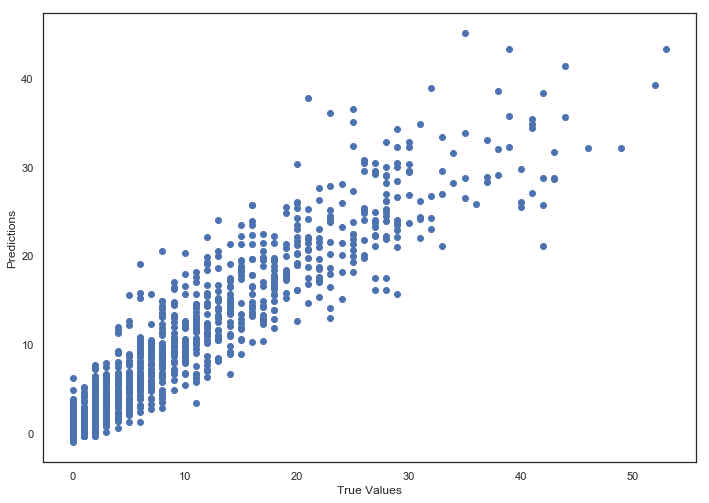

In [181]:

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [151]:
print('MAE: {}'.format(metrics.mean_absolute_error(y_test, predictions)))
print('MSE: {}'.format(metrics.mean_squared_error(y_test, predictions)))
print('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))

MAE: 2.5458758153467214
MSE: 13.939463556526688
RMSE: 3.7335591004464743


In [163]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [164]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [165]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 14.720119406131744
Test Mean Squarred Error: 13.939463556526688


There is not a significant difference between the train and test MSE!

Intersting note, the MSE of the Test data is smaller than the training data, a rare occurence. 

## K-Fold Cross Validation

In [168]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
cv_5_results  = np.mean(cross_val_score(linreg, Xs, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, Xs, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, Xs, y, cv=20, scoring='neg_mean_squared_error'))

In [170]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-14.790763253718954
-14.761320057047262
-14.747351578083046


By performing the K-Fold cross validation test, we can see that the negative mean squared error is not far off from each other. 

## Random Forest Regression

I used random forest regression to determine the features that are most important to the model

In [96]:
def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,                         n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return scores

In [97]:
rfr_model(Xs, y)

array([-2.8797993 , -2.65571317, -3.29078152, -2.38093775, -2.74261802,
       -2.73850571, -2.29469549, -2.30106772, -2.56003367, -2.37521269])

Feature: 0, Score: 0.09262
Feature: 1, Score: 0.18651
Feature: 2, Score: 0.10860
Feature: 3, Score: 0.09245
Feature: 4, Score: 0.09665
Feature: 5, Score: 0.09859
Feature: 6, Score: 0.13109
Feature: 7, Score: 0.09529
Feature: 8, Score: 0.09818


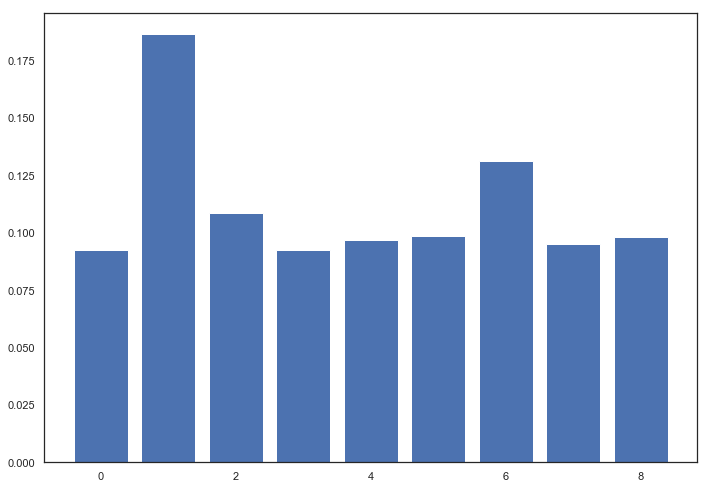

In [107]:
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot

model = RandomForestClassifier()
# fit the model
model.fit(Xs, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [108]:
Xs.head()

,assists,shots,hits,penaltyMinutes,blocked,plusMinus,evenTimeOnIce,takeawayDiff,faceOffWinP
0,6,60,59,14,16,3,31092,11,0.536364
1,43,231,4,46,9,16,79753,-23,0.000000
3,42,196,15,32,15,0,65413,-26,0.000000
5,12,50,17,6,6,7,17590,-5,1.000000
6,41,163,34,52,19,21,75169,-9,0.000000


## Stepwise Selection

In [86]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [160]:
stepwise_selection(Xs, y)


Add  shots                          with p-value 0.0
Add  blocked                        with p-value 5.03924e-115
Add  plusMinus                      with p-value 3.91462e-84
Add  assists                        with p-value 3.10061e-46
Add  takeawayDiff                   with p-value 6.68578e-06
Add  evenTimeOnIce                  with p-value 0.0073621


['shots', 'blocked', 'plusMinus', 'assists', 'takeawayDiff', 'evenTimeOnIce']

## Ridge Regression

In [161]:
ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error', cv=5)

ridge_regressor.fit(Xs, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [166]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 20}
-14.790445001419368
